# 🚗 Car Classification using Deep Learning
Project for Neural Networks and Deep Learning, A.Y. 2024/2025, by Lorenzo Martinelli (2125031), Arina Ponomareva (2106897), and Laura Schulze (2122311).
## Project Overview
This project focuses on **car classification** using deep learning.
We train a **convolutional neural network (CNN)** to classify car images into different categories using the **CompCars dataset**.

We explore **snapshot ensembling**, a technique that helps improve generalization by saving multiple model states during training. We also evaluate the impact of **dynamic data augmentation**,
which applies different augmentation strategies depending on class distribution.

The main objectives of this project are:
- **Preprocess and augment the dataset** to improve generalization.
- **Train a deep learning model** to classify car images.
- **Evaluate model performance** using accuracy, loss curves, and other metrics.
- **Compare standard vs. dynamic augmentation** to assess its impact on training.

## 📌 Notebook Structure
The notebook is structured into three main parts:
1. **Data Preprocessing**: Loading the dataset, applying transformations, and preparing data for training.
2. **Model Training**: Defining and training the CNN model.
3. **Testing and Results**: Evaluating the model and analyzing classification accuracy.

---

**Dataset:** [CompCars Dataset](http://mmlab.ie.cuhk.edu.hk/datasets/compcar.html)  

Library imports:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim.lr_scheduler as lr_scheduler

import os
import cv2
import random
import shutil

from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as ds
from torchvision.models import efficientnet_b0

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from PIL import Image
import copy
import os

Checking if the GPU is available:

In [ ]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("No GPU detected. Check CUDA installation.")


PyTorch Version: 2.2.0+cu118
CUDA Available: True
GPU Name: Tesla T4
CUDA Version: 11.8


# Data preprocessing

We first load the **CompCars dataset**, which consists of images from different car categories.
Each image is associated with a label representing its class.

In [ ]:
data_path = "/mnt/data/"

if os.path.exists(data_path):
    print( "Data path is accessible!")
    print("Files in data directory:", os.listdir(data_path))
else:
    print(" Data path NOT found! Check your dataset mount.")


Data path is accessible!
Files in data directory: ['image', 'label', 'misc', 'part', 'train_test_split']


## Splitting the Dataset

To ensure proper training and evaluation, we split the dataset into:
- **Training set**: 80% of the data.
- **Validation set**: 10% of the data (used for hyperparameter tuning).
- **Test set**: 10% of the data (used for final evaluation).

We use **stratified sampling** to maintain the same class distribution across the train, validation, and test sets.


In [ ]:
# Split train, validation, and test dataset
image_path = os.path.join(data_path, "image")
dataset = ds.ImageFolder(root = image_path)

all_data = dataset.samples

train_data, tmp_data = train_test_split(all_data, test_size = 0.2, stratify = [label for _, label in all_data])
val_data, test_data  = train_test_split(tmp_data, test_size = 0.5, stratify = [label for _, label in tmp_data])

Since we are using `ImageFolder`, class labels are automatically assigned based on subdirectories.
Here, we print the mapping of class names to numerical labels.


In [ ]:
# check how labels are extracted from ImageFolder
print(dataset.class_to_idx)

To get a better understanding of the dataset, we randomly select and display **10 images** from a specific car category.
This helps us:
- Verify the **quality** and **variety** of images in the dataset.
- Check for **potential issues** such as low resolution, noise, or incorrect labeling.


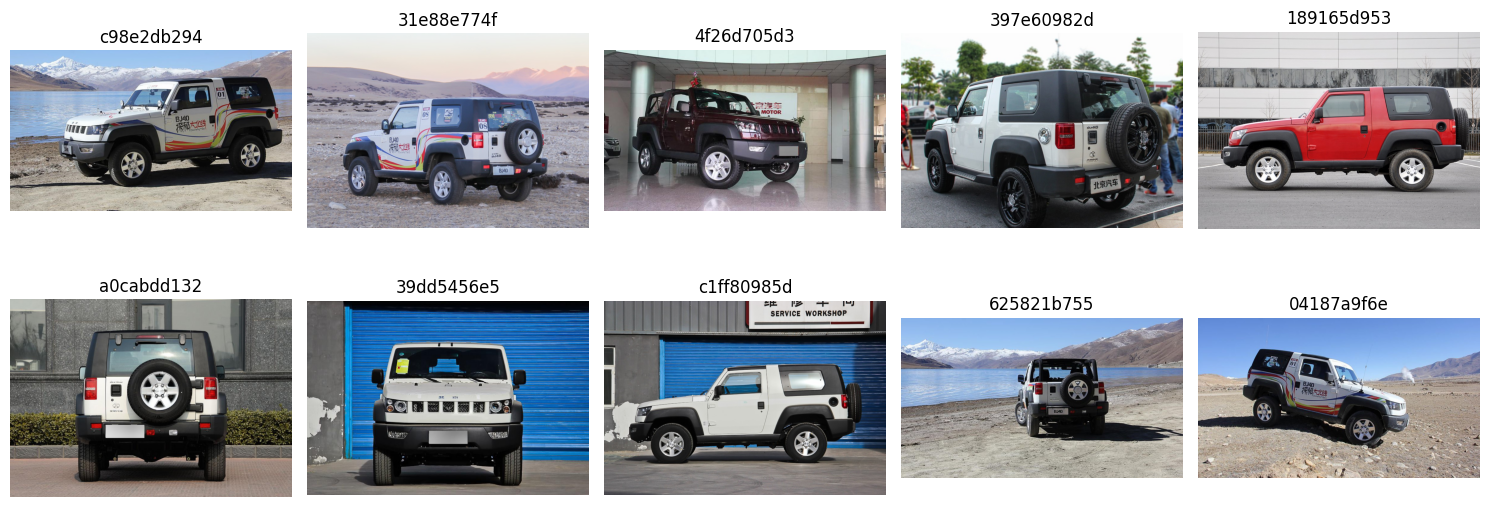

In [ ]:
# Get all image files
image_files = [f for f in os.listdir(image_path +'/58/327/2014') if f.endswith(('.jpg', '.png'))]

# Select 10 random images
random_images = random.sample(image_files, 10)

# Set up the figure (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Loop through selected images and display them
for ax, img_name in zip(axes.flat, random_images):
    img_path = os.path.join(image_path+'/58/327/2014', img_name)

    # Load image using OpenCV
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Show image
    ax.imshow(image)
    ax.set_title(img_name[:10])  # Display part of the filename as title
    ax.axis("off")  # Hide axis

# Adjust layout
plt.tight_layout()
plt.show()


To understand the dataset distribution, we count the number of images available for each **car make** (brand).  
This information helps us:
- Identify **class imbalances** (some car brands may have significantly fewer images).
- Decide on the **appropriate augmentation strategy** (stronger augmentation for underrepresented classes).


In [ ]:
make_counts = {}

# Loop through car makes
for make in os.listdir(image_path):
    make_path = os.path.join(image_path, make)

    if os.path.isdir(make_path):  # Ensure it's a directory
        make_counts[make] = sum(
            len(files) for _, _, files in os.walk(make_path) if files
        )

# Print results
for make, count in make_counts.items():
    print(f"Make {make}: {count} images")


Make 1: 133 images
Make 10: 16 images
Make 100: 2492 images
Make 101: 718 images
Make 102: 2926 images
Make 103: 1145 images
Make 104: 105 images
Make 105: 1937 images
Make 106: 167 images
Make 107: 2 images
Make 108: 1935 images
Make 109: 202 images
Make 11: 954 images
Make 110: 742 images
Make 111: 2166 images
Make 112: 769 images
Make 113: 224 images
Make 114: 1424 images
Make 115: 299 images
Make 116: 276 images
Make 117: 581 images
Make 118: 3786 images
Make 119: 120 images
Make 12: 120 images
Make 120: 574 images
Make 121: 120 images
Make 122: 3974 images
Make 123: 561 images
Make 124: 210 images
Make 125: 210 images
Make 126: 188 images
Make 127: 575 images
Make 128: 344 images
Make 129: 120 images
Make 13: 29 images
Make 130: 129 images
Make 131: 1520 images
Make 132: 794 images
Make 133: 221 images
Make 134: 1569 images
Make 135: 133 images
Make 136: 410 images
Make 137: 801 images
Make 138: 72 images
Make 139: 1124 images
Make 14: 618 images
Make 140: 3220 images
Make 141: 40

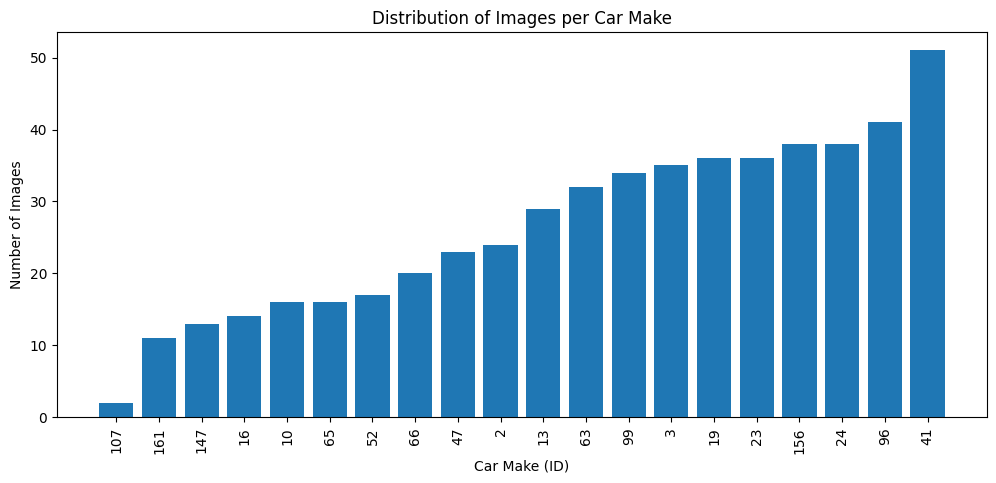

In [ ]:
# Sort by number of images
sorted_makes = sorted(make_counts.items(), key=lambda x: x[1], reverse=False)

# Extract top 20 makes
bottom_makes, bottom_counts = zip(*sorted_makes[:20])

# Plot
plt.figure(figsize=(12, 5))
plt.bar(bottom_makes, bottom_counts)
plt.xticks(rotation=90)
plt.xlabel("Car Make (ID)")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Car Make")
plt.show()


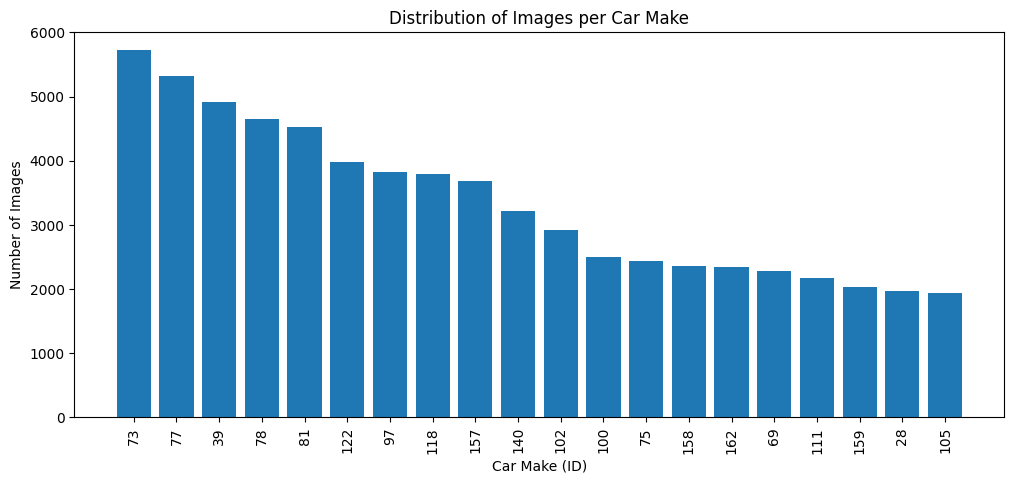

In [ ]:
# Sort by number of images
sorted_makes = sorted(make_counts.items(), key=lambda x: x[1], reverse=True)

# Extract top 20 makes
top_makes, top_counts = zip(*sorted_makes[:20])

# Plot
plt.figure(figsize=(12, 5))
plt.bar(top_makes, top_counts)
plt.xticks(rotation=90)
plt.xlabel("Car Make (ID)")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Car Make")
plt.show()


## Dataset Imbalance Analysis

To better understand the distribution of images per class, we categorize them into different sample size ranges:
- **Extremely low-sample classes**: Fewer than **10 images**.
- **Low-sample classes**: Between **10 and 100 images**.
- **Medium-low sample classes**: Between **100 and 500 images**.
- **Medium sample classes**: Between **500 and 1000 images**.
- **Medium-high sample classes**: Between **1000 and 2000 images**.
- **High-sample classes**: Between **2000 and 3000 images**.
- **Extremely high-sample classes**: More than **3000 images**.

This analysis helps identify:
- **Rare classes** that may cause model bias.
- **Where augmentation is needed** (e.g., stronger augmentation for underrepresented classes).
-**Potential class weighting strategies** during training.

The following cells print out how many classes belong to each category.


Extremely Low-Sample Classes ( <10 images )

These classes have very few images, making classification difficult.  


In [ ]:
extremely_low_sample_classes = {make: count for make, count in make_counts.items() if count < 10}

print(f"Number of classes with <10 images: {len(extremely_low_sample_classes)}")
print("Classes with extremely low samples:", extremely_low_sample_classes)

Number of classes with <10 images: 1
Classes with extremely low samples: {'107': 2}


Low-Sample Classes ( 10 < n < 100 images )

These classes are slightly better represented but **still highly imbalanced**.  



In [ ]:
low_sample_classes = {make: count for make, count in make_counts.items() if 10 < count < 100}

print(f"Number of classes with 100 > n > 10 images: {len(low_sample_classes)}")
print("Classes with low samples:", low_sample_classes)

Number of classes with 100 > n > 10 images: 28
Classes with low samples: {'10': 16, '13': 29, '138': 72, '144': 63, '147': 13, '156': 38, '16': 14, '161': 11, '17': 75, '18': 64, '19': 36, '2': 24, '20': 53, '23': 36, '24': 38, '25': 94, '3': 35, '40': 78, '41': 51, '47': 23, '52': 17, '63': 32, '65': 16, '66': 20, '8': 88, '9': 96, '96': 41, '99': 34}


Medium-Low Sample Classes ( 100 < n < 500 images )

These classes have a **moderate** amount of images but might still require **light augmentation**.


In [ ]:
medium_low_sample_classes = {make: count for make, count in make_counts.items() if 100 < count < 500}

print(f"Number of classes with 500 > n > 100 images: {len(medium_low_sample_classes)}")
print("Classes with medium low samples:", medium_low_sample_classes)

Number of classes with 500 > n > 100 images: 58
Classes with medium low samples: {'1': 133, '104': 105, '106': 167, '109': 202, '113': 224, '115': 299, '116': 276, '119': 120, '12': 120, '121': 120, '124': 210, '125': 210, '126': 188, '128': 344, '129': 120, '130': 129, '133': 221, '135': 133, '136': 410, '141': 409, '143': 389, '146': 312, '155': 275, '163': 328, '21': 352, '22': 265, '26': 390, '29': 236, '30': 170, '32': 180, '34': 195, '42': 118, '43': 354, '44': 287, '46': 162, '49': 165, '5': 424, '56': 175, '57': 385, '59': 230, '6': 183, '60': 422, '61': 239, '62': 103, '67': 206, '72': 312, '74': 155, '79': 175, '80': 262, '82': 491, '83': 476, '85': 161, '86': 240, '89': 314, '90': 120, '91': 126, '93': 136, '98': 139}


Medium Sample Classes ( 500 < n < 1000 images )

These classes have a **good amount of images**, making them more balanced.  
They may still benefit from **mild augmentation** for better generalization.


In [ ]:
medium_sample_classes = {make: count for make, count in make_counts.items() if 500 < count < 1000}

print(f"Number of classes with 1000 > n > 500 images: {len(medium_sample_classes)}")
print("Classes with medium samples:", medium_sample_classes)

Number of classes with 1000 > n > 500 images: 34
Classes with medium samples: {'101': 718, '11': 954, '110': 742, '112': 769, '117': 581, '120': 574, '123': 561, '127': 575, '132': 794, '137': 801, '14': 618, '142': 927, '148': 689, '151': 669, '153': 574, '31': 543, '33': 542, '35': 601, '36': 794, '37': 647, '4': 652, '50': 686, '51': 629, '58': 546, '64': 653, '68': 958, '7': 618, '70': 623, '71': 706, '76': 509, '84': 760, '87': 538, '88': 959, '92': 869}


Medium-High Sample Classes ( 1000 < n < 2000 images )

These classes have a **strong representation** in the dataset.  
They usually **do not require augmentation** but may benefit from **mild transformations**.


In [ ]:
medium_high_sample_classes = {make: count for make, count in make_counts.items() if 1000 < count < 2000}

print(f"Number of classes with 2000 > n > 1000 images: {len(medium_high_sample_classes)}")
print("Classes with medium high samples:", medium_high_sample_classes)

Number of classes with 2000 > n > 1000 images: 24
Classes with medium high samples: {'103': 1145, '105': 1937, '108': 1935, '114': 1424, '131': 1520, '134': 1569, '139': 1124, '145': 1449, '149': 1893, '15': 1570, '150': 1693, '152': 1690, '154': 1138, '160': 1758, '27': 1420, '28': 1966, '38': 1394, '45': 1050, '48': 1070, '53': 1115, '54': 1840, '55': 1176, '94': 1187, '95': 1619}


High-Sample Classes ( 2000 < n < 3000 images )

These classes are **well-represented** in the dataset.  
In most cases, they **do not require augmentation** and can serve as a **strong baseline**.


In [ ]:
high_sample_classes = {make: count for make, count in make_counts.items() if 2000 < count < 3000}

print(f"Number of classes with 3000 > n > 2000 images: {len(high_sample_classes)}")
print("Classes with high samples:", high_sample_classes)

Number of classes with 3000 > n > 2000 images: 8
Classes with high samples: {'100': 2492, '102': 2926, '111': 2166, '158': 2355, '159': 2029, '162': 2339, '69': 2283, '75': 2440}


Extremely High-Sample Classes ( >3000 images )

These classes dominate the dataset and can create a bias in the model.  
They typically **do not need augmentation**.


In [ ]:
extremely_high_sample_classes = {make: count for make, count in make_counts.items() if 3000 < count}

print(f"Number of classes with  n > 3000 images: {len(extremely_high_sample_classes)}")
print("Classes with extremely high samples:", extremely_high_sample_classes)

Number of classes with  n > 3000 images: 10
Classes with extremely high samples: {'118': 3786, '122': 3974, '140': 3220, '157': 3688, '39': 4908, '73': 5720, '77': 5319, '78': 4657, '81': 4531, '97': 3831}


##Car classification is a challenging task due to:
- **High intra-class variability** (same model appearing in different lighting conditions, angles, and modifications).
- **Severe class imbalance** (some car models have thousands of images, while others have very few).
- **Overfitting risk** due to certain classes being overrepresented.

To **improve model generalization** and **handle dataset imbalance**, we compare two augmentation strategies:

### 1️⃣ Standard Augmentation (Fixed)
- Applied **the same augmentation** to all images.
- Balanced the dataset by **undersampling overrepresented classes**.
- Ensured a more **even class distribution** during training.

### 2️⃣ Dynamic Augmentation (Per-Class)
- Instead of undersampling, we **applied different augmentations based on class size**:
  - **Strong augmentation** for small classes (**<500** images) to artificially boost diversity.
  - **Light augmentation** for medium classes (**500-2000** images) to introduce mild transformations.
  - **Minimal augmentation** for large classes (**>2000** images) to preserve data quality.
- This **preserved all available images** while enhancing model robustness.

In [ ]:
print(train_data[0])
print(val_data[0])

('/mnt/data/image/162/1630/2014/c7c0900aefb6b4.jpg', 70)
('/mnt/data/image/122/622/2008/94b6b5d130f641.jpg', 26)


## Standard Augmentation (Fixed)
In this approach, we:
- Apply **the same augmentation** to all images.
- Handle class imbalance by **undersampling larger classes**.
- Use a balanced dataset for training.




In [ ]:
import random

augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 15, translate = (.2, .2)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

val_test_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
  def __init__(self, data, transforms = None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    path, label = self.data[idx]
    image = Image.open(path).convert("RGB")

    if self.transforms is not None:
      image = self.transforms(image)

    return image, label

def balance_data(data):
  label_counts = Counter([label for _, label in data])
  class_data = {label: [] for label in label_counts}
  balanced_data = []

  for path, label in data:
    class_data[label].append((path, label))

  for label, items in class_data.items():
    count = len(items)

    if count < 500:
      balanced_data.extend(items)

    elif 500 <= count < 2000:
      balanced_data.extend(random.sample(items, int(count * 0.75)))

    else:
      balanced_data.extend(random.sample(items, int(count * 0.50)))

  return balanced_data

class ImageDataset(Dataset):
  def __init__(self, data, transforms = None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    path, label = self.data[idx]
    image = Image.open(path).convert("RGB")

    if transforms is not None:
      image = self.transforms(image)

    return image, label

balanced_train_data = balance_data(train_data)
train_dataset = ImageDataset(balanced_train_data, augmentation)
val_dataset   = ImageDataset(val_data, val_test_augmentation)
test_dataset  = ImageDataset(test_data, val_test_augmentation)

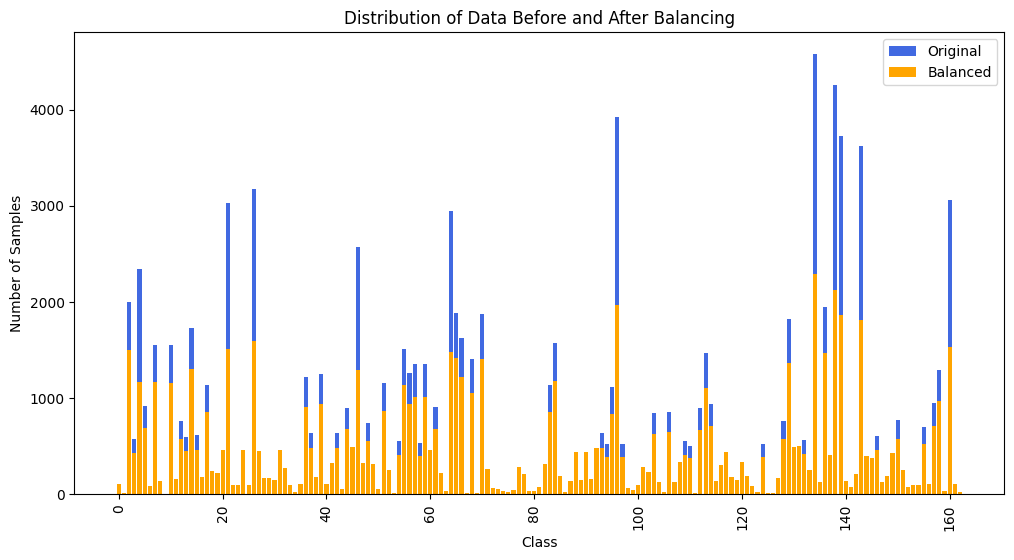

In [ ]:
# See the distribution of classes after the balancing
label_counts = Counter([label for _, label in train_data])
label_counts_balanced = Counter([label for _, label in balanced_train_data])

plt.figure(figsize = (12, 6))
plt.bar(label_counts.keys(), label_counts.values(), label = 'Original',
        color = 'royalblue')
plt.bar(label_counts_balanced.keys(), label_counts_balanced.values(),
        label = 'Balanced', color = 'orange')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Data Before and After Balancing")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [ ]:
label_counts_ordered = dict(sorted(label_counts_balanced.items()))
print(label_counts_ordered)
print()

{0: 106, 1: 13, 2: 1495, 3: 430, 4: 1170, 5: 687, 6: 84, 7: 1162, 8: 134, 9: 2, 10: 1161, 11: 162, 12: 572, 13: 445, 14: 1299, 15: 461, 16: 179, 17: 854, 18: 239, 19: 221, 20: 465, 21: 1514, 22: 96, 23: 96, 24: 459, 25: 96, 26: 1589, 27: 449, 28: 168, 29: 168, 30: 150, 31: 460, 32: 275, 33: 96, 34: 23, 35: 103, 36: 912, 37: 476, 38: 177, 39: 941, 40: 106, 41: 328, 42: 480, 43: 58, 44: 674, 45: 494, 46: 1288, 47: 327, 48: 556, 49: 311, 50: 50, 51: 869, 52: 250, 53: 11, 54: 413, 55: 1135, 56: 942, 57: 1015, 58: 401, 59: 1014, 60: 459, 61: 682, 62: 220, 63: 31, 64: 1475, 65: 1413, 66: 1217, 67: 11, 68: 1054, 69: 9, 70: 1403, 71: 262, 72: 60, 73: 51, 74: 29, 75: 19, 76: 42, 77: 282, 78: 212, 79: 29, 80: 31, 81: 75, 82: 312, 83: 852, 84: 1179, 85: 189, 86: 28, 87: 136, 88: 434, 89: 144, 90: 434, 91: 156, 92: 481, 93: 476, 94: 388, 95: 836, 96: 1963, 97: 391, 98: 62, 99: 41, 100: 94, 101: 283, 102: 230, 103: 630, 104: 130, 105: 19, 106: 642, 107: 132, 108: 339, 109: 411, 110: 377, 111: 14, 1

##Dynamic Augmentation (Per-Class)
Instead of balancing the dataset, we:
- **Adapt augmentation based on class size**:
  - **Strong augmentation** for small classes (<500 images).
  - **Light augmentation** for medium classes (500–2000 images).
  - **Minimal augmentation** for large classes (>2000 images).
- Use a **custom dataset class** that assigns the correct transformation dynamically.

This approach helps retain **all available data** while improving generalization for underrepresented classes.


In [ ]:
strong_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Light augmentation for medium classes
light_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Minimal augmentation for large classes (or no augmentation)
minimal_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def get_transforms(class_name, class_counts):
    """
    Applies different augmentation strategies based on class sizes.
    - Strong Augmentation: For small classes (n < 500)
    - Light Augmentation: For medium classes (500 ≤ n < 2000)
    - Minimal Augmentation: For large classes (n ≥ 2000)
    """
    class_size = class_counts[class_name]  # Get number of images in the class

    if class_size < 500:
        return strong_augmentation  # Apply strong augmentation
    elif 500 <= class_size < 2000:
        return light_augmentation  # Apply light augmentation
    else:
        return minimal_augmentation  # Apply minimal augmentation

# Create a dictionary mapping each class to its augmentation
transform_dict = {class_name: get_transforms(class_name, make_counts) for class_name in make_counts.keys()}

In [ ]:
val_test_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

class ImageDatasetWithAugmentation(Dataset):
  def __init__(self, data, transform_dict, class_labels):

    self.data = data
    self.transform_dict = transform_dict
    self.class_labels = class_labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    path, label = self.data[idx]
    image = Image.open(path).convert("RGB")

    class_name = self.class_labels[label]
    transform = self.transform_dict.get(class_name, None)  # Get transform, or None

    if transform is not None:
        image = transform(image)

    return image, label

class ImageDataset(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    path, label = self.data[idx]
    image = Image.open(path).convert("RGB")

    if self.transforms is not None:
      image = self.transforms(image)

    return image, label

In [ ]:
# Create datasets
train_dataset = ImageDatasetWithAugmentation(train_data, transform_dict, dataset.classes)
val_dataset = ImageDataset(val_data, val_test_augmentation)
test_dataset = ImageDataset(test_data, val_test_augmentation)

##Loading Data & Preparing DataLoaders

Once the dataset is preprocessed and transformed, we need to load it into **PyTorch DataLoaders** for efficient batch processing during training and validation.

###Creating DataLoaders
We define a batch size of **512** and create DataLoaders for:
- **Training Data** (`train_loader`): Shuffled to ensure different batch compositions.
- **Validation Data** (`val_loader`): Not shuffled since validation data remains consistent.
- **Test Data** (`test_loader`): Used for final model evaluation.



In [ ]:
# Create DataLoaders
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")


Train samples: 77305 | Validation samples: 13673 | Test samples: 13673


In [ ]:
images, labels = next(iter(train_loader))
print(f"Batch size: {images.shape[0]}")

Batch size: 512


In [ ]:
print("Image batch shape:", images.shape)  # Expected: (512, 3, 224, 224)

Image batch shape: torch.Size([512, 3, 224, 224])


Let's visualize a batch of images from our train_loader after augmentations have been applied

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-d9l_d_v1'


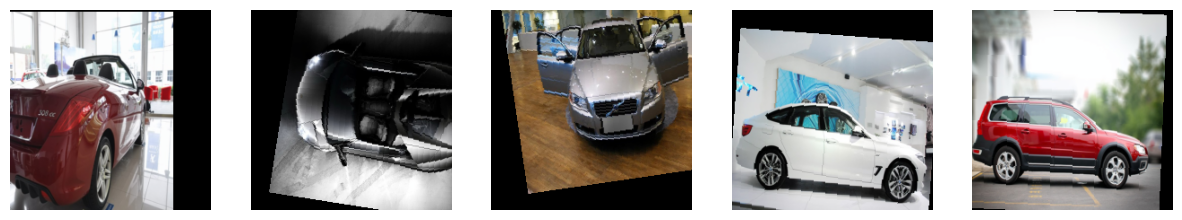

In [ ]:
# Get one batch from the train_loader
images, labels = next(iter(train_loader))


# Convert image tensors to numpy for visualization
def imshow(img, ax):
    img = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) → (H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Ensure pixel values are in range [0,1]
    ax.imshow(img)  # Use ax to display image

# Ensure at least 5 images are displayed
num_images = min(5, images.shape[0])  # If fewer than 5 images exist, adjust


fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    imshow(images[i], axes[i])
    axes[i].axis("off")  # Hide axes

plt.show()

In [ ]:
print("Done with data preprocessing!")

Done with data preprocessing!


# Model Training: EfficientNet with Snapshot Ensembling

##Overview
Now that we have implemented **data preprocessing** and **augmentation strategies**, we can define the model architecture and training approach.  

Our approach is based on **Snapshot Ensembling**, a technique that periodically saves model snapshots at different epochs to construct an ensemble from multiple training stages.

---

##**Model Architecture: EfficientNet-B0**
The selected architecture for this classification task is **EfficientNet-B0**, the simplest model from the EfficientNet family developed by Google.

Why **EfficientNet-B0**?
- It achieves **high accuracy with fewer parameters** due to its compound scaling.
- It was **pre-trained** on ImageNet, allowing us to leverage **transfer learning** instead of training from scratch.

Since EfficientNet was trained on a **different dataset**, we modify its classifier head to match our **number of classes**.





In [ ]:
# Get the number of classes after we filter the extremely rare ones
N_cl = len(label_counts)

model = efficientnet_b0(pretrained = True)          # Import the model

# Change the network so that it has the right amount of output classes
n_features = model.classifier[1].in_features
model.classifier = nn.Linear(n_features, N_cl)

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##Fine-Tuning: Freezing Initial Layers

EfficientNet-B0 consists of multiple **stages**. Instead of training the entire model from scratch, we take advantage of **transfer learning** by:

**Freezing the first five stages** to retain pre-trained knowledge from ImageNet.  
**Training only the final three stages** (Stage 7, 8, and the classifier head) to adapt the model to our dataset.  

This approach speeds up training and prevents overfitting, especially when working with smaller datasets.

In [ ]:
# Freeze stages 1 through 5
# First, freeze ALL stages
for param in model.parameters():
  param.requires_grad = False       # Block the SGD for all parameters

for layer in model.features[-3:]:
  for param in layer.parameters():
    param.requires_grad = True       # Unlock the SGD for the last two blocks of the network


for param in model.classifier.parameters():
  param.requires_grad = True         # Unlock the SGD for the classifier


# Transfer the model to the device (GPU, if available)
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

##Loss Function, Learning Rate, and Optimizer

To optimize the training process, we carefully select the following components:

###Loss Function: Focal Loss
- Standard **Cross-Entropy Loss** struggles with imbalanced datasets.
- **Focal Loss** adjusts the loss contribution, focusing on **hard-to-classify examples** while reducing the impact of well-classified samples.
- This prevents the model from being **dominated by majority classes**.

Focal Loss is especially useful in cases where certain classes are significantly underrepresented. Instead of treating all samples equally, it applies **scaling factors** so that rare and difficult samples contribute more to the overall loss.

---

###Dynamic Learning Rate: Shifted Cosine Annealing
Instead of keeping a **fixed learning rate**, we implement **Shifted Cosine Annealing**, inspired by Loshchilov & Hutter (2016).  

This technique:
- Periodically **reduces the learning rate**, preventing overshooting.
- Encourages **convergence** while avoiding getting stuck in local minima.
- Helps balance between **exploration** and **stability**.

The learning rate follows a cosine function, decreasing gradually before increasing again. This **cyclic approach** helps the model generalize better, as it avoids getting stuck in local minima too early.

---

###Optimizer: Adam
The **Adam Optimizer** is chosen for its ability to:
- Adapt learning rates dynamically for each parameter.
- Handle sparse gradients effectively.
- Perform well across various deep learning tasks.

Adam combines the advantages of **momentum-based optimizers** and **adaptive learning rate methods**, making it well-suited for deep learning applications.

---

###Finalizing Training Setup
To adjust Focal Loss for class imbalance, we compute class frequencies.  
This ensures that **underrepresented classes** have a greater contribution to the overall loss:

- We calculate the **number of samples per class** in the dataset.
- A weight (**alpha**) is assigned to each class based on its frequency.
- The rarer the class, the **higher its weight**, preventing it from being ignored by the model.

This weighting strategy makes sure that the model does not **overfit to majority classes**, improving its generalization ability across different car makes.



In [ ]:
# Define the number of epochs
num_epochs = 30
# Define the number of snapshots
num_snapshots = np.ceil(num_epochs / 5)

# Choose only the parameters that can be require a gradient
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

# Choose the optimizer: Adam
optimizer = optim.Adam(trainable_params, lr = 0.1)    # High initial learning rate, but it's variable due to snapshot ensembles

# Define the focal loss
class FocalLoss(nn.Module):
  def __init__(self, gamma, alpha, reduction = 'sum'):
    super(FocalLoss, self).__init__()
    self.gamma = gamma
    self.alpha = alpha
    self.reduction = reduction

  def forward(self, logits, targets):
    probs = F.softmax(logits, dim = -1)
    targets_one_hot = F.one_hot(targets, num_classes = logits.shape[1]).float()

    # Compute the X-entropy
    ce_loss = -targets_one_hot * torch.log(probs + 1e-9)   # Avoid log0 issues
    p_true = (probs * targets_one_hot).sum(dim = -1)

    # Apply the focal loss scaling factor
    focal_weight = (1 - p_true) ** self.gamma
    focal_weight = focal_weight.unsqueeze(-1)
    focal_loss = focal_weight * ce_loss

    # Apply alpha weighting
    if self.alpha is not None:
      alpha_factor = self.alpha.to(targets.device)[targets].unsqueeze(1)
      focal_loss *= alpha_factor

    # Reduce loss
    if self.reduction == "mean":
      return focal_loss.sum() / targets_one_hot.sum()
    elif self.reduction == "sum":
      return focal_loss.sum()
    else:
      return focal_loss

# Utilize the LR seen in the paper of Huang, Li et al. (2016)
class ShiftedCosineLR(lr_scheduler.LambdaLR):
  def __init__(self, optimizer, init_lr, T, M):
    self.init_lr = init_lr          # Initial learning rate
    self.T = T                      # Total number of epochs
    self.M = M                      # Number of snapshots
    self.T_m = math.ceil(T/M)       # Epochs per cycle for a snapshot

    super().__init__(optimizer, self.lr_lambda)

  def lr_lambda(self, epoch):
    epoch_tensor = torch.tensor(math.pi * ((epoch % self.T_m) / self.T_m))  # Convert to tensor
    return 0.5 * (1 + torch.cos(epoch_tensor))


# Set an alpha value for the Focal Loss
class_counts = torch.tensor([label_counts_balanced[i] for i in sorted(label_counts_balanced.keys())], dtype=torch.float32)

alpha = 1.0 / (class_counts + 1e-6)  # Avoid division by zero

alpha = alpha / alpha.sum()

##Hyperparameter Search: Fine-Tuning Focal Loss & Learning Rate

Before launching the full training process, we must **fine-tune key hyperparameters** to maximize model performance.

###Key Hyperparameters to Tune:
- **Gamma (𝛾)** in **Focal Loss**:
  - Determines how much the model focuses on hard-to-classify samples.
  - A higher value gives more weight to difficult samples.
  - Tested values: **2.0, 5.0**.

- **Initial Learning Rate (𝜂₀)**:
  - Defines how quickly the model updates weights.
  - Lower values result in slow but stable training.
  - Tested values: **0.01, 0.001**.

---

###Setting Up the Search
To efficiently find the best hyperparameters:
1. We **train a dummy EfficientNet-B0 model** for **15 epochs** (a reduced training cycle).
2. We **iterate over different values of gamma (𝛾) and learning rate (𝜂₀)**.
3. After every training cycle, we:
   - Compute **validation accuracy**.
   - Store results in a **CSV file** for later analysis.
   - Update the **best hyperparameter combination** if a better accuracy is found.

---

After testing, we select the **best (𝛾, 𝜂₀) combination** based on the highest validation accuracy.

This ensures we are using the **most effective loss scaling and learning rate** before training the final model!

In [ ]:
test_input = torch.randn(1, 3, 224, 224).to(device)  # A single image
test_output = model(test_input)
print("Model output shape:", test_output.shape)  # Should be [1, N_cl]

Model output shape: torch.Size([1, 163])


/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
print(model.classifier)  # Check if classifier is correctly updated

Linear(in_features=1280, out_features=163, bias=True)


In [ ]:
import csv
drive_dir = "/home/ubuntu/hyperparameters"
os.makedirs(drive_dir, exist_ok=True)
csv_file_path = os.path.join(drive_dir, 'progression_gamma_lr.csv')

df = pd.DataFrame(columns = ['gamma', 'lr_init', 'val_accuracy'])
df.to_csv(csv_file_path, index = False)

In [ ]:
print("Starting Hyperparameter Search!")

Starting Hyperparameter Search!


In [ ]:
gamma_values = [2.0, 5.0]
lr_values = [0.01,  0.001]

best_gamma = None
best_lr = None
best_val_accuracy = 0.0

num_epochs_reduced = 15      # Train for fewer epochs

for gamma in gamma_values:
  for lr_init in lr_values:
    model_dummy = efficientnet_b0(pretrained = True)
    model_dummy.classifier = nn.Linear(n_features, N_cl)
    for param in model_dummy.parameters():
      param.requires_grad = False
    for layer in model_dummy.features[-2:]:
      for param in layer.parameters():
        param.requires_grad = True
    for param in model_dummy.classifier.parameters():
      param.requires_grad = True
    model_dummy.to(device)

    trainable_params_dummy = filter(lambda p: p.requires_grad, model_dummy.parameters())
    optimizer = optim.Adam(trainable_params_dummy, lr = lr_init)
    scheduler = ShiftedCosineLR(optimizer, init_lr = lr_init,
                                T = num_epochs_reduced, M = num_snapshots)
    loss_fn = FocalLoss(gamma = gamma, alpha = alpha)

    for epoch in range(num_epochs_reduced):
      print(f"Epoch = {epoch + 1}")
      model_dummy.train()
      epoch_train_loss = 0

      for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_dummy(images)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      scheduler.step()

      model_dummy.eval()
      with torch.no_grad():
        correct_predictions = 0
        total_samples       = 0

        for images, labels in tqdm(val_loader):
          images, labels = images.to(device), labels.to(device)
          predictions = model_dummy(images)
          predicted_classes = torch.argmax(predictions, dim = 1)

          correct_predictions += (predicted_classes == labels).sum().item()
          total_samples += labels.size(0)

        val_accuracy = correct_predictions / total_samples
        print(f"Gamma: {gamma}, Learning Rate: {lr_init}, Validation Accuracy: {val_accuracy}")

      with open('progression_gamma_lr.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([gamma, lr_init, val_accuracy])

      if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_gamma = gamma
        best_lr = lr_init



print(f"Best Gamma: {best_gamma}, Best Learning Rate: {best_lr}, Best Validation Accuracy: {best_val_accuracy}")

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch = 1


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.10283039567029913
Epoch = 2


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.1919110656037446
Epoch = 3


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.25466247348789584
Epoch = 4


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.23827982154611277
Epoch = 5


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.29949535581072184
Epoch = 6


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.37270533167556497
Epoch = 7


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.339062385723689
Epoch = 8


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.3995465515980399
Epoch = 9


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.4568858333942807
Epoch = 10


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.3862356468953412
Epoch = 11


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.4525707598917575
Epoch = 12


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.498793242156074
Epoch = 13


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.42375484531558544
Epoch = 14


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.65s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.46646675930666276
Epoch = 15


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 2.0, Learning Rate: 0.01, Validation Accuracy: 0.5306809039713304
Epoch = 1


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.65s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.13296277334893586
Epoch = 2


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.21407152782856725
Epoch = 3


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:45<00:00,  1.68s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.2604402837709354
Epoch = 4


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:45<00:00,  1.67s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.30073868207416077
Epoch = 5


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.35997952168507275
Epoch = 6


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.39077013091494184
Epoch = 7


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.3970598990711621
Epoch = 8


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.43318949754991587
Epoch = 9


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.4636875594236817
Epoch = 10


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.45542309661376434
Epoch = 11


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.4888466320485629
Epoch = 12


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.5167117677173992
Epoch = 13


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.49776932640971255
Epoch = 14


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.5234403569077745
Epoch = 15


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 2.0, Learning Rate: 0.001, Validation Accuracy: 0.5546697871717985
Epoch = 1


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.11292327945586192
Epoch = 2


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.17735683463760696
Epoch = 3


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.26080596796606453
Epoch = 4


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.23381847436553793
Epoch = 5


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.3187303444745118
Epoch = 6


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.39552402545161996
Epoch = 7


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.34337745922621227
Epoch = 8


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.39969282527609157
Epoch = 9


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.4632487383895268
Epoch = 10


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.3730710158706941
Epoch = 11


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.4429898339793754
Epoch = 12


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.508008483873327
Epoch = 13


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.64s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.4386016236378264
Epoch = 14


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.4863599795216851
Epoch = 15


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.01, Validation Accuracy: 0.534849703795802
Epoch = 1


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.1394719520222336
Epoch = 2


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.22855262195567908
Epoch = 3


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.67s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.2724347253711695
Epoch = 4


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.3051268924157098
Epoch = 5


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.3555181745044979
Epoch = 6


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.3923791413735098
Epoch = 7


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.40020478314927227
Epoch = 8


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.43070284502303813
Epoch = 9


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.46310246471147515
Epoch = 10


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.4492796021355957
Epoch = 11


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:44<00:00,  1.65s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.48080157975572296
Epoch = 12


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.5142982520295473
Epoch = 13


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.48789585314122724
Epoch = 14


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.5163460835222702
Epoch = 15


100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]

Gamma: 5.0, Learning Rate: 0.001, Validation Accuracy: 0.5458933664887003
Best Gamma: 2.0, Best Learning Rate: 0.001, Best Validation Accuracy: 0.5546697871717985


In [ ]:
print("Done with hyperparameter search!")

Done with hyperparameter search!


##Model Training with Snapshot Ensembling

Now that we have chosen the **best hyperparameters**, we proceed to train the model using **EfficientNet-B0** with **Snapshot Ensembling**.

###Key Training Setup:
- **Loss Function:** **Focal Loss** (to handle class imbalance)
- **Optimizer:** **Adam** with the best learning rate found in hyperparameter search (**𝜂₀ = 0.001**)
- **Learning Rate Scheduling:** **Shifted Cosine LR** (to cyclically adjust the learning rate)
- **Epochs:** **30** (Snapshots saved every **5 epochs**)

---

###Training Loop Workflow:
1️⃣ **Training Phase**:
   - Forward pass: Compute outputs using **EfficientNet-B0**.
   - Compute **Focal Loss** and update model weights.
   - Track **training loss** at each epoch.

2️⃣ **Validation Phase**:
   - Evaluate the model **without gradient updates**.
   - Compute **validation loss and accuracy**.
   - Store **validation performance** for analysis.

3️⃣ **Snapshot Saving**:
   - Every **5 epochs**, a checkpoint is saved, storing:
     - Model weights (`model_state_dict`)
     - Optimizer state (`optimizer_state_dict`)
     - Training loss & validation loss
     - Validation accuracy



In [ ]:
# Define the loss and the optimizer for good now
best_lr = 0.001
best_gamma = 2.0

trainable_params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(trainable_params, lr = best_lr)
scheduler = ShiftedCosineLR(optimizer, init_lr = best_lr, T = num_epochs,
                            M = num_snapshots)
loss_fn = FocalLoss(gamma = best_gamma, alpha = alpha)

In [ ]:
### Training loop ###
# Lists to keep track of losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  print(f"Epoch: {epoch+1}")
  epoch_train_loss = 0
  iterator = tqdm(train_loader)

  # Training phase
  for images, labels in iterator:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()

    iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")


  epoch_train_loss /= len(train_loader)
  train_losses.append(epoch_train_loss)

  # Validation phase
  model.eval()
  with torch.no_grad():
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in tqdm(val_loader):
      images, labels = images.to(device), labels.to(device)

      y_pred = model(images)
      val_loss += loss_fn(y_pred, labels).item()

      # Accuracy
      predicted_classes = torch.argmax(y_pred, dim = 1)
      correct_predictions += (predicted_classes == labels).sum().item()
      total_predictions += labels.size(0)

    # Compute average validation loss for this epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Compute validation accuracy as well
    val_accuracy = correct_predictions / total_predictions
    print(f"Loss: {val_loss}, Accuracy: {val_accuracy}")

    # Next step in the scheduler
    scheduler.step()

  if (epoch + 1) % 5 == 0:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_loss': epoch_train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }

    torch.save(checkpoint, f'/home/ubuntu/checkpoint_{epoch + 1}.pth')

    print(f"Snapshot saved at epoch {epoch+1}")

Epoch: 1


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Loss: 0.2796791046857834, Accuracy: 0.6398010677978497
Epoch: 2


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Loss: 0.27351223318665113, Accuracy: 0.6543552987639875
Epoch: 3


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


Loss: 0.20516499159512697, Accuracy: 0.7213486433116361
Epoch: 4


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Loss: 0.1819491778258924, Accuracy: 0.7580633365025964
Epoch: 5


100%|███████████████████████████████████████████| 27/27 [00:44<00:00,  1.66s/it]


Loss: 0.17622658610343933, Accuracy: 0.7685219044832883
Snapshot saved at epoch 5
Epoch: 6


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Loss: 0.2343023066167478, Accuracy: 0.6999926863160975
Epoch: 7


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Loss: 0.22173088402659805, Accuracy: 0.7378775689314708
Epoch: 8


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Loss: 0.19237372913846262, Accuracy: 0.7558692313318218
Epoch: 9


100%|███████████████████████████████████████████| 27/27 [00:45<00:00,  1.69s/it]


Loss: 0.16294505778286192, Accuracy: 0.7883419878592848
Epoch: 10


100%|███████████████████████████████████████████| 27/27 [00:44<00:00,  1.65s/it]


Loss: 0.1574055905695315, Accuracy: 0.8016528925619835
Snapshot saved at epoch 10
Epoch: 11


100%|███████████████████████████████████████████| 27/27 [00:45<00:00,  1.68s/it]


Loss: 0.23857094678613874, Accuracy: 0.7254443062970818
Epoch: 12


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Loss: 0.19885188893035607, Accuracy: 0.7559423681708477
Epoch: 13


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Loss: 0.1705390822004389, Accuracy: 0.7876106194690266
Epoch: 14


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Loss: 0.15906297029168517, Accuracy: 0.8056022818693777
Epoch: 15


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Loss: 0.15062260765720298, Accuracy: 0.8168653550793534
Snapshot saved at epoch 15
Epoch: 16


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Loss: 0.21528222494655186, Accuracy: 0.7444598844437943
Epoch: 17


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Loss: 0.19149863499182243, Accuracy: 0.7685219044832883
Epoch: 18


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Loss: 0.16289086281149476, Accuracy: 0.7998976084253638
Epoch: 19


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Loss: 0.15187542581999744, Accuracy: 0.820668470708696
Epoch: 20


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Loss: 0.14544589513981784, Accuracy: 0.8279821546112777
Snapshot saved at epoch 20
Epoch: 21


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


Loss: 0.19487476817987584, Accuracy: 0.7631097783953777
Epoch: 22


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


Loss: 0.21523190455304253, Accuracy: 0.7598917574782418
Epoch: 23


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Loss: 0.17435008563377238, Accuracy: 0.7977035032545894
Epoch: 24


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


Loss: 0.15221259025511918, Accuracy: 0.8298105755869232
Epoch: 25


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.59s/it]


Loss: 0.14649612180612706, Accuracy: 0.8387332699480728
Snapshot saved at epoch 25
Epoch: 26


100%|███████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Loss: 0.2063615965070548, Accuracy: 0.7757624515468442
Epoch: 27


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.62s/it]


Loss: 0.18859960911450563, Accuracy: 0.7958750822789439
Epoch: 28


100%|███████████████████████████████████████████| 27/27 [00:44<00:00,  1.63s/it]


Loss: 0.1622221632688134, Accuracy: 0.81745044979156
Epoch: 29


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.60s/it]


Loss: 0.14072808650908647, Accuracy: 0.8369048489724275
Epoch: 30


100%|███████████████████████████████████████████| 27/27 [00:44<00:00,  1.65s/it]

Loss: 0.13669022062310465, Accuracy: 0.8456812696555255
Snapshot saved at epoch 30


Let's plot the training and validation losses throughout the epochs

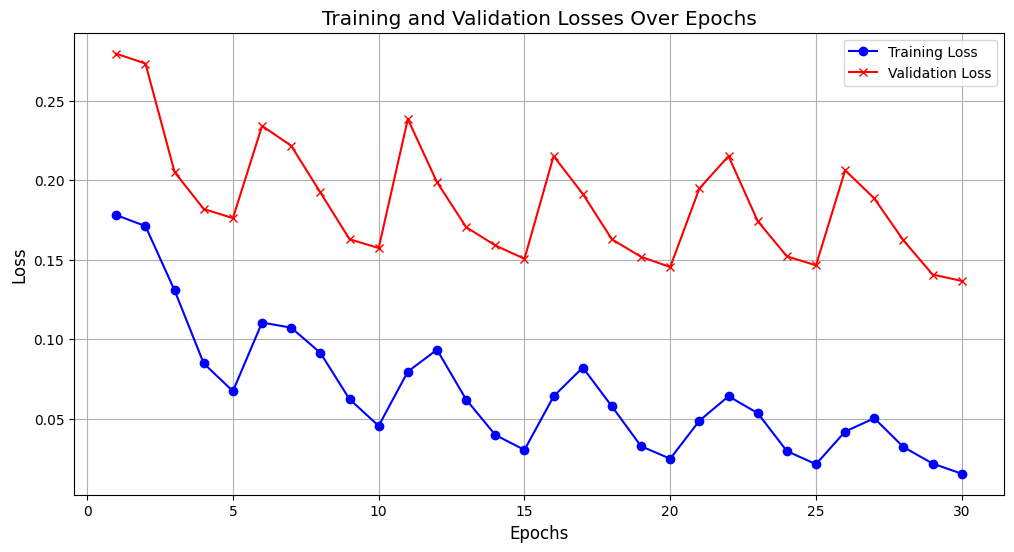

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label = "Training Loss",
         color = "Blue", linestyle = "-", marker = "o")
plt.plot(range(1, num_epochs + 1), val_losses, label = "Validation Loss",
         color = "Red", linestyle = "-", marker = "x")
plt.xlabel("Epochs", fontsize = "large")
plt.ylabel("Loss", fontsize = "large")
plt.title("Training and Validation Losses Over Epochs", fontsize = "x-large")
plt.legend(loc = "best")
plt.grid(True)
plt.show()

#Model Testing & Evaluation

Now that we have trained our model and obtained multiple **snapshot instances**, it's time to evaluate its performance on the **test dataset**.



###**Building the Snapshot Ensemble**
Since we have saved **snapshots** of our model at different training stages (every **5 epochs**), we need to:
- Load all saved models (`checkpoint_X.pth`).
- Reconstruct the model architecture.
- Load each snapshot's weights.
- Reverse the order of snapshots for convenience.

Each of these models contributes to our **ensemble** by making predictions on the test dataset.

---

###**Evaluating Top-1 and Top-5 Accuracy**
To measure how well the model generalizes, we compute:
- **Top-1 Accuracy**: The fraction of test samples where the highest-confidence prediction is correct.
- **Top-5 Accuracy**: The fraction of test samples where the correct label appears among the **top 5 predictions**.

For **each ensemble size** (from **1 snapshot to all snapshots**):
1. The test images are passed through **m models**.
2. The predictions from all **m** models are **averaged** to form the final probability distribution.
3. The **Top-1** and **Top-5 accuracies** are computed and stored.

---



In [ ]:
snapshot_paths = [f"/home/ubuntu/checkpoint_{epoch}.pth" for epoch in range(5, num_epochs+1, 5)]
model = efficientnet_b0(pretrained = False)
model.classifier[1] = nn.Linear(in_features = 1280, out_features = N_cl)
model.to(device)

snapshots = []
for path in snapshot_paths:

  checkpoint = torch.load(path)
  checkpoint_state_dict = checkpoint['model_state_dict']

  new_state_dict = {}
  for key, value in checkpoint_state_dict.items():
      new_key = key.replace('classifier.weight', 'classifier.1.weight').replace('classifier.bias', 'classifier.1.bias')
      new_state_dict[new_key] = value

  model.load_state_dict(new_state_dict)
  model.eval()
  snapshots.append(copy.deepcopy(model))

snapshots.reverse()         # Reverse the list for simplicity later on

m_list = np.arange(1, len(snapshots) + 1)       # Change the amount of elements in the ensemble

# Store the top1 and top5 accuracies
top1s = []
top5s = []

################### TEST TIME ###################
with torch.no_grad():
  for m in m_list:
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0
    for images, labels in tqdm(test_loader):
      images, labels = images.to(device), labels.to(device)
      total_samples += labels.size(0)

      avg_probs = None
      for model in snapshots[:m]:
        prediction = model(images)
        probabilities = F.softmax(prediction, dim = 1)

        if avg_probs is None:
          avg_probs = probabilities.clone()
        else:
          avg_probs += probabilities

      avg_probs /= m

      top_1_pred = torch.argmax(avg_probs, dim = 1)
      top_5_pred = torch.topk(avg_probs, k = 5, dim = 1).indices

      correct_top1 += (top_1_pred == labels).sum().item()
      correct_top5 += (top_5_pred == labels.unsqueeze(1)).sum().item()

    top1_acc = correct_top1 / total_samples
    top5_acc = correct_top5 / total_samples
    top1s.append(top1_acc)
    top5s.append(top5_acc)

    print(f"-------------------------------------------------------------------")
    print(f"Number of snapshots: {m}")
    print(f"    Top-1 Accuracy: {top1_acc:.4f}")
    print(f"    Top-5 Accuracy: {top5_acc:.4f}")

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.61s/it]


-------------------------------------------------------------------
Number of snapshots: 1
    Top-1 Accuracy: 0.8485
    Top-5 Accuracy: 0.9637


100%|███████████████████████████████████████████| 27/27 [00:43<00:00,  1.63s/it]


-------------------------------------------------------------------
Number of snapshots: 2
    Top-1 Accuracy: 0.8552
    Top-5 Accuracy: 0.9648


100%|███████████████████████████████████████████| 27/27 [00:50<00:00,  1.87s/it]


-------------------------------------------------------------------
Number of snapshots: 3
    Top-1 Accuracy: 0.8559
    Top-5 Accuracy: 0.9667


100%|███████████████████████████████████████████| 27/27 [01:05<00:00,  2.43s/it]


-------------------------------------------------------------------
Number of snapshots: 4
    Top-1 Accuracy: 0.8567
    Top-5 Accuracy: 0.9676


100%|███████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


-------------------------------------------------------------------
Number of snapshots: 5
    Top-1 Accuracy: 0.8533
    Top-5 Accuracy: 0.9668


100%|███████████████████████████████████████████| 27/27 [01:35<00:00,  3.53s/it]

-------------------------------------------------------------------
Number of snapshots: 6
    Top-1 Accuracy: 0.8495
    Top-5 Accuracy: 0.9658


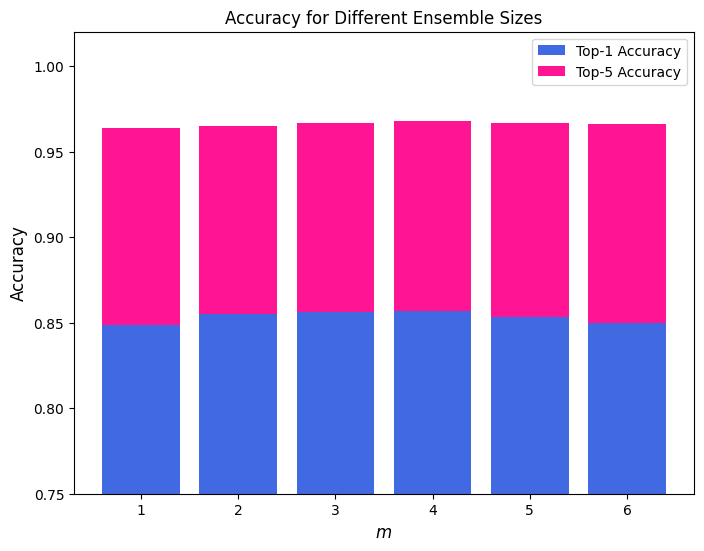

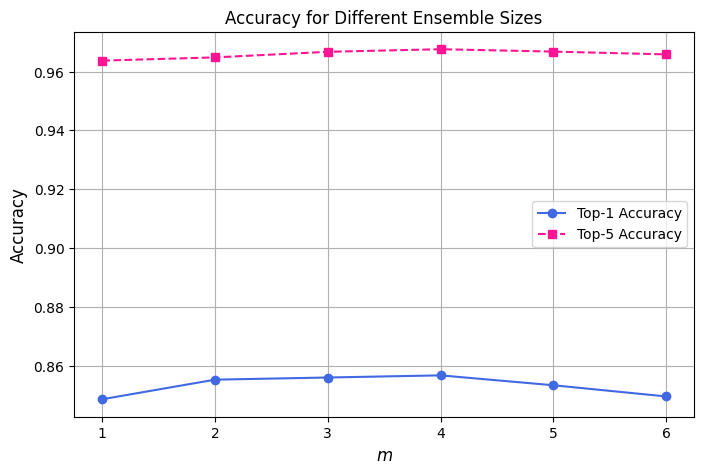

In [ ]:
################### PLOT THE RESULTS ###################
# Histogram
plt.figure(figsize=(8, 6))
plt.bar(m_list, top1s, label = "Top-1 Accuracy", color = 'royalblue')
plt.bar(m_list, np.array(top5s) - np.array(top1s), bottom = top1s, label = "Top-5 Accuracy", color = 'deeppink')

plt.xlabel("$m$", fontsize = 'large')
plt.ylabel("Accuracy", fontsize = 'large')
plt.xticks(m_list)
plt.title("Accuracy for Different Ensemble Sizes", fontsize = 'large')
plt.ylim(0.75, 1.02)
plt.legend()
plt.show()

# Line Plot
plt.figure(figsize=(8, 5))
plt.plot(m_list, top1s, marker = 'o', linestyle = '-', color = 'royalblue', label = 'Top-1 Accuracy')
plt.plot(m_list, top5s, marker = 's', linestyle = '--', color = 'deeppink', label = "Top-5 Accuracy")
plt.xlabel('$m$', fontsize = 'large')
plt.ylabel('Accuracy', fontsize = 'large')
plt.xticks(m_list)
plt.title("Accuracy for Different Ensemble Sizes", fontsize = 'large')
plt.grid(True)
plt.legend()
plt.show()

## Dynamic Augmentation Training (External Notebook)

The **training for the Dynamic Augmentation model** was conducted in **a separate Jupyter notebook**, meaning that the step-by-step training results are **not available here**.  

However, since we saved **checkpoint snapshots** for both the **Standard** and **Dynamic Augmentation** models, we can still compare their performance.  

To do this, we will **load the saved checkpoints** and analyze their:
- **Validation loss** over epochs
- **Top-1 and Top-5 accuracy** using the ensemble approach

This will allow us to **compare both augmentation strategies fairly**, even though the Dynamic Augmentation training is not fully detailed in this notebook.
